In [1]:
import torch
from tqdm import tqdm
import numpy as np
import sys
import matplotlib.pyplot as plt
import importlib
import pandas as pd
from scipy.stats import norm 

from utils import checkpoint, warning
import utils
import MCHMC, MCLMC
import autotuning as aut
import integration_schemes as integ
import functions as funct
import metrics

np.random.seed(0)

In [2]:
importlib.reload(utils)
importlib.reload(MCHMC)
importlib.reload(MCLMC)
importlib.reload(aut)
importlib.reload(integ)
importlib.reload(funct)
importlib.reload(metrics);

## Global parameter optimization

In [3]:
fn = funct.neals_funnel
d = 20
n_chains = 5

In [18]:
# create a csv file with the optimal hyperparameters value for all possible combinations (don't need to run it each time)
# aut.get_hyperparams(fn=fn, d=d, L_init=np.sqrt(d), output_csv='neals_funnel_hyperparams.cvs')


Running 5 iterations of MCHMC_bounces with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]



Running 5 iterations of MCHMC_bounces with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]



Running 5 iterations of MCHMC_bounces with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]



Running 5 iterations of MCHMC_bounces with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]



Running 5 iterations of MCLMC with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]



Running 5 iterations of MCLMC with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]



Running 5 iterations of MCLMC with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.34s/it]



Running 5 iterations of MCLMC with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


In [4]:
# load it 
df = pd.read_csv('hyperparameters/neals_funnel_hyperparams.cvs')
df

,algorithm,integ_scheme,eps,L
0,MCHMC_bounces,leapfrog,0.829495,4.095958
1,MCHMC_bounces,minimal_norm,1.729484,10.800046
2,MCLMC,leapfrog,0.694774,7.154165
3,MCLMC,minimal_norm,1.269765,11.682786


# Micro Canonical Hamiltonian Monte Carlo 
## Leapfrog 

In [5]:
row = df[(df['algorithm'] == 'MCHMC_bounces') & (df['integ_scheme'] == 'leapfrog')]
eps = row['eps'].values[0]
L = row['L'].values[0]

X, ess_mean, ess_min, _ = MCHMC.MCHMC_chain(n_chains, d, fn, L, eps, int_scheme=integ.leapfrog)

/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
100%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 224.75it/s]
E0715 13:06:59.542196  338394 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.5.1 but source was compiled with: 9.8.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0715 13:06:59.542971  338394 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.5.1 but source was compiled with: 9.8.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loade

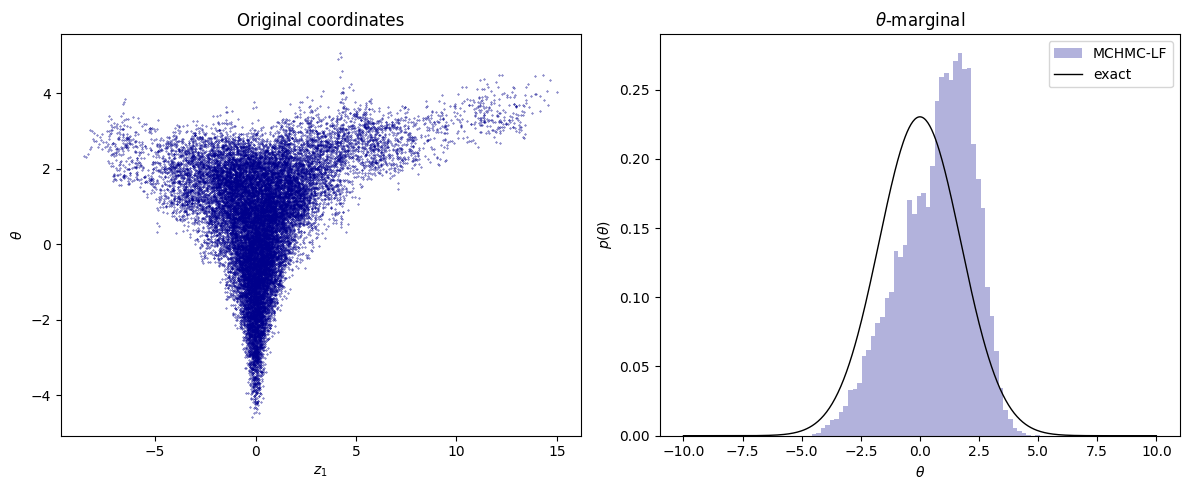

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(X[:, 1], X[:, 0], s=0.1, color='darkblue')
ax[0].set_xlabel(r'$z_1$')
ax[0].set_ylabel(r'$\theta$')
ax[0].set_title(r'Original coordinates')

thetas = np.linspace(-10, 10, 500)
ax[1].hist(X[:, 0], bins=50, density=True, alpha=0.3, color='darkblue', label='MCHMC-LF')
ax[1].plot(thetas, norm.pdf(thetas, loc=0, scale=np.sqrt(3)), lw=1, label='exact', color='black')
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel(r'$p(\theta$)')
ax[1].legend()
ax[1].set_title(r'$\theta$-marginal')

plt.tight_layout()
plt.savefig('./plots/neals_hamiltonian_LF.svg', format='svg')
plt.show()

In [9]:
print(f'ESS with MCHMC-bounces and LF integrator \n mean: {ess_mean:.3f} \n min: {ess_min:.3f}')

ESS with MCHMC-bounces and LF integrator 
 mean: nan 
 min: nan


## Minimal norm

In [10]:
row = df[(df['algorithm'] == 'MCHMC_bounces') & (df['integ_scheme'] == 'minimal_norm')]
eps = row['eps'].values[0]
L = row['L'].values[0]

X, ess_mean, ess_min, ess_truth = MCHMC.MCHMC_chain(n_chains, d, fn, L, eps, int_scheme=integ.minimal_norm)

100%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 164.63it/s]


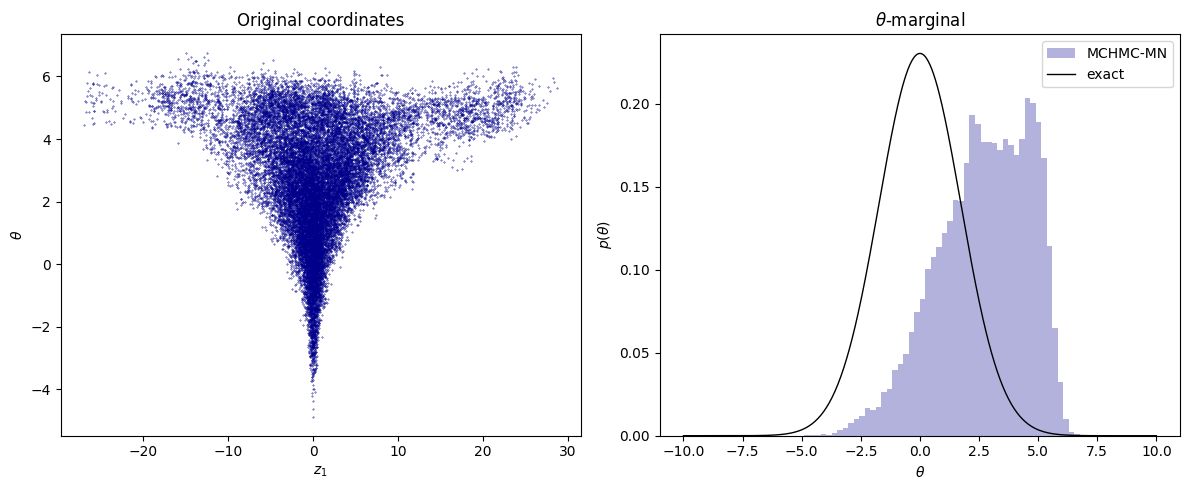

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(X[:, 1], X[:, 0], s=0.1, color='darkblue')
ax[0].set_xlabel(r'$z_1$')
ax[0].set_ylabel(r'$\theta$')
ax[0].set_title(r'Original coordinates')

thetas = np.linspace(-10, 10, 500)
ax[1].hist(X[:, 0], bins=50, density=True, alpha=0.3, color='darkblue', label='MCHMC-MN')
ax[1].plot(thetas, norm.pdf(thetas, loc=0, scale=np.sqrt(3)), lw=1, label='exact', color='black')
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel(r'$p(\theta$)')
ax[1].legend()
ax[1].set_title(r'$\theta$-marginal')

plt.tight_layout()
plt.savefig('./plots/gaussian_hamiltonian_MN.svg', format='svg')
plt.show()


In [12]:
print(f'ESS with MCHMC-bounces and MN integrator \n mean: {ess_mean:.3f} \n min: {ess_min:.3f}')

ESS with MCHMC-bounces and MN integrator 
 mean: nan 
 min: nan


---------
# Langevin Like Hamiltonian Monte Carlo 
## Leapfrog

In [13]:
row = df[(df['algorithm'] == 'MCLMC') & (df['integ_scheme'] == 'leapfrog')]
eps = row['eps'].values[0]
eps = torch.tensor(eps, device=utils.choose_device())
L = row['L'].values[0]
L = torch.tensor(L, device=utils.choose_device())

X, ess_mean, ess_min, ess_truth = MCLMC.MCLMC_chain(n_chains, d, fn, L, eps, int_scheme=integ.leapfrog)

100%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 215.50it/s]


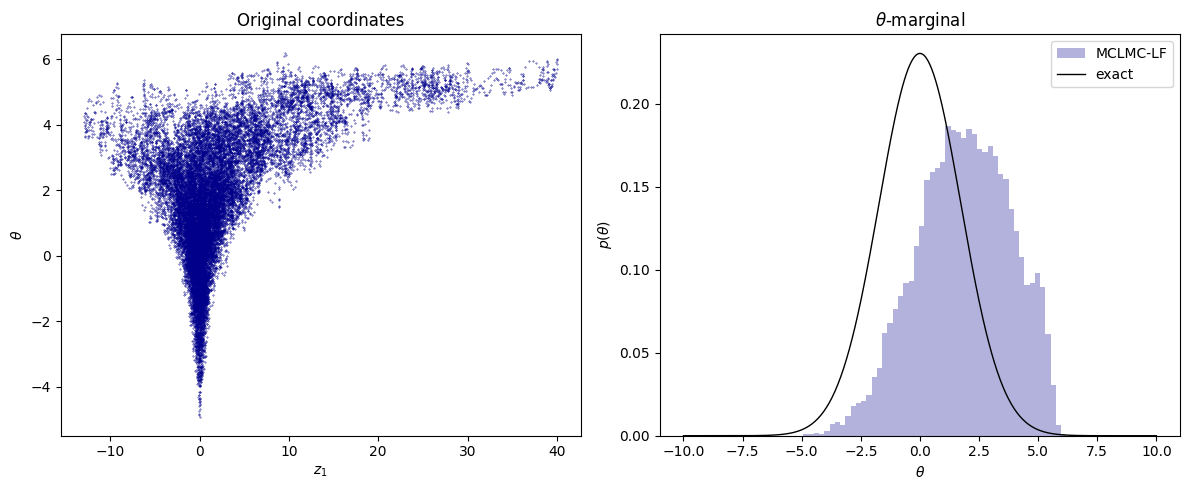

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(X[:, 1], X[:, 0], s=0.1, color='darkblue')
ax[0].set_xlabel(r'$z_1$')
ax[0].set_ylabel(r'$\theta$')
ax[0].set_title(r'Original coordinates')

thetas = np.linspace(-10, 10, 500)
ax[1].hist(X[:, 0], bins=50, density=True, alpha=0.3, color='darkblue', label='MCLMC-LF')
ax[1].plot(thetas, norm.pdf(thetas, loc=0, scale=np.sqrt(3)), lw=1, label='exact', color='black')
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel(r'$p(\theta$)')
ax[1].legend()
ax[1].set_title(r'$\theta$-marginal')

plt.tight_layout()
plt.savefig('./plots/gaussian_langevin_LF.svg', format='svg')
plt.show()


In [15]:
print(f'ESS with MCLMC and LF integrator \n mean: {ess_mean:.3f} \n min: {ess_min:.3f}')

ESS with MCLMC and LF integrator 
 mean: nan 
 min: nan


## Minimal norm

In [16]:
row = df[(df['algorithm'] == 'MCLMC') & (df['integ_scheme'] == 'minimal_norm')]
eps = row['eps'].values[0]
eps = torch.tensor(eps, device=utils.choose_device())
L = row['L'].values[0]
L = torch.tensor(L, device=utils.choose_device())

X, ess_mean, ess_min, ess_truth = MCLMC.MCLMC_chain(n_chains, d, fn, L, eps, int_scheme=integ.minimal_norm)

100%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 157.84it/s]


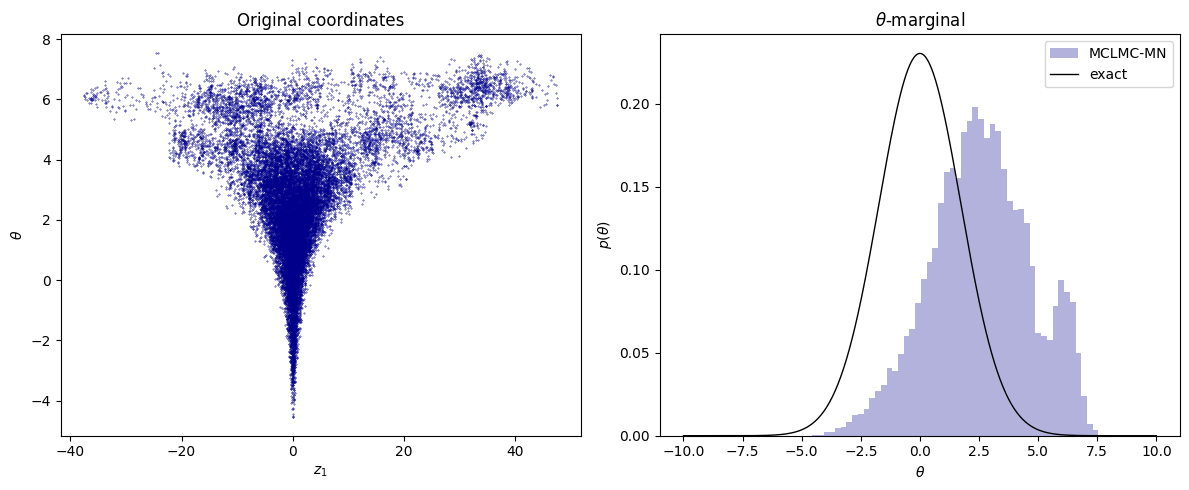

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(X[:, 1], X[:, 0], s=0.1, color='darkblue')
ax[0].set_xlabel(r'$z_1$')
ax[0].set_ylabel(r'$\theta$')
ax[0].set_title(r'Original coordinates')

thetas = np.linspace(-10, 10, 500)
ax[1].hist(X[:, 0], bins=50, density=True, alpha=0.3, color='darkblue', label='MCLMC-MN')
ax[1].plot(thetas, norm.pdf(thetas, loc=0, scale=np.sqrt(3)), lw=1, label='exact', color='black')
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel(r'$p(\theta$)')
ax[1].legend()
ax[1].set_title(r'$\theta$-marginal')

plt.tight_layout()
plt.savefig('./plots/gaussian_langevin_MN.svg', format='svg')
plt.show()


In [18]:
print(f'ESS with MCLMC and MN integrator \n mean:  {ess_mean:.3f} \n min: {ess_min:.3f}')

ESS with MCLMC and MN integrator 
 mean:  0.023 
 min: nan
